In [1]:
import pandas as pd
import numpy as np
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [4]:
times = pd.read_excel(processed_dir/'times_ivt_jan25.xlsx')


In [5]:
times = (times
 .assign(Parent = lambda x: x['Chemical name'].ffill())
)

In [6]:
times = (times
 .assign(Parent_id = lambda df: df['Chemical name'].apply(
        lambda x: 'Parent' if isinstance(x, str)  else x
    ))
)

In [18]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import grakel
import networkx as nx

In [19]:
def smi_inchi(x):
    mol = Chem.MolFromSmiles(x)
    clean_smi = Chem.MolToSmiles(mol, isomericSmiles=False)
    clean_mol = Chem.MolFromSmiles(clean_smi)
    inchi =     Chem.MolToInchi(clean_mol)
    inchi_key = Chem.InchiToInchiKey(inchi)
    return inchi_key

In [20]:
newlst = []

# Sort the DataFrame by 'Parent' and any other relevant column, such as 'Level of generation'
times = times.sort_values(by=['Parent', 'Level of generation']).reset_index(drop=True)

# Iterate over each group
for i, group in times.groupby('Parent'):
    subset = group[['Parent', 'Parent_id']]
    # Define a counter for generating unique identifiers
    counter = 1
    # Iterate over rows in the subset
    for index, row in subset.iterrows():
        if row['Parent_id'] == 'Parent':
            newlst.append(row['Parent'])  # Use the parent ID as is
        else:
            # Append with a unique identifier based on the counter
            newlst.append(row['Parent'] + '_m_' + str(counter))
            # Increment the counter
            counter += 1

In [21]:
len(newlst)

6897

In [22]:
times.shape

(6897, 23)

In [23]:
times['ID'] = newlst

In [24]:
times.columns

Index(['#', 'ID of metabolite', 'Level of generation', 'Predecessor ID', 'CAS',
       'Chemical name', 'SMILES', 'Observed map/metabolite',
       'Transformation name', 'Transformation No', 'Transformation ID',
       'Transformation probability group', 'Transformation expert group',
       'Transformation type', 'Transformation probability', 'Used probability',
       'Enzyme(s)', 'Quantity of metabolite', 'Total quantity of metabolite',
       'Number of repetitions', 'Parent', 'Parent_id', 'ID'],
      dtype='object')

In [25]:
inchi_keys = {}
errors = []
for k,v in zip(times['ID'], times['SMILES']):
    try:
        X = smi_inchi(v)
    except Exception as error:
        errors.append(error)
    else:
        inchi_keys[k] = X


[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Omitted undefined stereo

[13:44:38] WARNING: Charges were rearranged

[13:44:38] WARNING: Charges were rearranged

[13:44:38] WARNING: Charges were rearranged

[13:44:38] WARNING: Charges were rearranged; Omitted undefined stereo

[13:44:38] WARNING: Charges were rearranged

[13:44:38] WA

In [27]:
len(inchi_keys)

6897

In [28]:
df_inchi = pd.DataFrame(inchi_keys.items(), columns = ['ID', 'INCHI_KEY'])

times = pd.merge(times, df_inchi, on = 'ID', how = 'left')

In [29]:
times1 = (times
 .rename(columns=lambda col: col.replace(' ', '_'))
 .assign(transformation = lambda df : df['Transformation_name'].apply(
        lambda x: x.split('|')[0] if isinstance(x, str) and '|' in x else x
    )) 
 .filter(items = ['ID_of_metabolite', 'Level_of_generation', 'Predecessor_ID',  'Chemical_name', 'SMILES',  'Parent', 'Parent_id', 'ID', 'INCHI_KEY',
       'transformation'])
)

In [30]:
times1.to_csv(raw_dir/'times1.csv')

In [31]:
transformation_types = times1['transformation'].unique().tolist()

In [41]:
n_transformations= len(transformation_types)

In [33]:
def generate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024))
    else:
        return None

In [34]:
edges = times1[times1['Predecessor_ID'] != '-']

In [35]:
times1['Fingerprint'] = times1['SMILES'].apply(generate_fingerprint)

In [36]:
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

In [37]:
transformation_index = {t: i for i, t in enumerate(transformation_types)}

In [38]:
def create_node_label(row):
    # Concatenate the desired columns for more expressive labels
    return f"ID: {row['ID']}"

In [39]:
# Group data by 'Parent'
groups = times1.groupby('Parent')

# Initialize a dictionary to store graphs
graph_dict = {}

In [43]:
groups = times1.groupby('Parent')

# Initialize a dictionary to store graphs
graph_dict = {}
for parent, group in groups:
    # Initialize a directed graph for this parent
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for _, row in group.iterrows():
        label = create_node_label(row)
        G.add_node(
            row['ID_of_metabolite'],
            chemical_name=row['Chemical_name'],
            SMILES=row['SMILES'],
            label=label,
            fingerprint=row['Fingerprint'],
            ID = row['ID']
        )
   # Convert bit vector labels to strings
    for node in G.nodes():
        fingerprint_tuple = str(G.nodes[node]['fingerprint'])
        
        G.nodes[node]['label'] = fingerprint_tuple

    # Add edges with sparse one-hot encoded transformation types
    for _, row in group.iterrows():
        if row['Predecessor_ID'] != '-':  # Skip root nodes without predecessors
            transformation_type = row['transformation']  # Define this logic
            index = transformation_index[transformation_type]
            
            # Create sparse one-hot encoding for the edge
            sparse_vector = lil_matrix((1, n_transformations))
            sparse_vector[0, index] = 1
            
            G.add_edge(
                row['Predecessor_ID'],
                row['ID_of_metabolite'],
                transformation_type=transformation_type,
                sparse_one_hot=sparse_vector
            )
    
    
    
    # Store the grakel graph in the dictionary
    graph_dict[parent] = G

In [45]:
my_graphs = list(graph_dict.values())

In [46]:
my_grakel_graphs = grakel.graph_from_networkx(my_graphs, node_labels_tag='label')  #

In [47]:
wl_kernel = grakel.WeisfeilerLehman(base_graph_kernel=grakel.VertexHistogram,normalize=True)
kernel_scores = pd.DataFrame(wl_kernel.fit_transform(my_grakel_graphs))


In [51]:
kernel_scores.index = graph_dict.keys()
kernel_scores.columns = graph_dict.keys()
kernel_scores

,DTXSID0020151,DTXSID0020232,DTXSID0020440,DTXSID0020494,DTXSID0020498,DTXSID0020523,DTXSID0020529,DTXSID0020575,DTXSID0021206,DTXSID0021254,...,No_Stearate_sorbitol,Nocas_2747537,Pubchem_102283661,Pubchem_102283662,Pubchem_102283665,Pubchem_102283668,Pubchem_138190,Pubchem_162521585,Pubchem_54176852,Pubchem_562248
DTXSID0020151,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.507093
DTXSID0020232,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.0,0.475497,0.0,0.450631,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
DTXSID0020440,0.000000,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
DTXSID0020494,0.000000,0.0,0.0,1.000000,0.696311,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
DTXSID0020498,0.000000,0.0,0.0,0.696311,1.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pubchem_102283668,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.220276,0.0,0.830645,0.193548,1.000000,1.000000,0.0,0.0,0.209677,0.263280
Pubchem_138190,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000
Pubchem_162521585,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000
Pubchem_54176852,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.220276,0.0,0.072581,0.000000,0.209677,0.209677,0.0,0.0,1.000000,0.263280


In [61]:
kernel_scores.to_csv(processed_dir/'WL_times_ivt.csv')

In [50]:
len(graph_dict)

620

In [52]:
df1 = pd.read_csv(interim_dir/'icf_processed_170125.csv', index_col = [0])

In [53]:
mydict = {}
for i, group in df1.groupby('Index'):
    subset = list(group['dtxsid'])
    mydict[i] = subset

In [56]:
wl_dict = {}
for k,v in mydict.items():
    try:
        v1 = kernel_scores[kernel_scores.index.isin(mydict[k])] 
        v2 = v1[v1.columns.intersection(mydict[k])]
        mk = np.triu(np.ones(v2.shape), k=0)
        b2 = v2.where(mk==1, np.nan).unstack().reset_index().dropna()
        b2 = b2[b2['level_0'] != b2['level_1']]
        b2 = b2.iloc[:,2].values
    except Exception as error:
        print(error)
    finally:
        wl_dict[k] = b2

/home/grace/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/grace/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


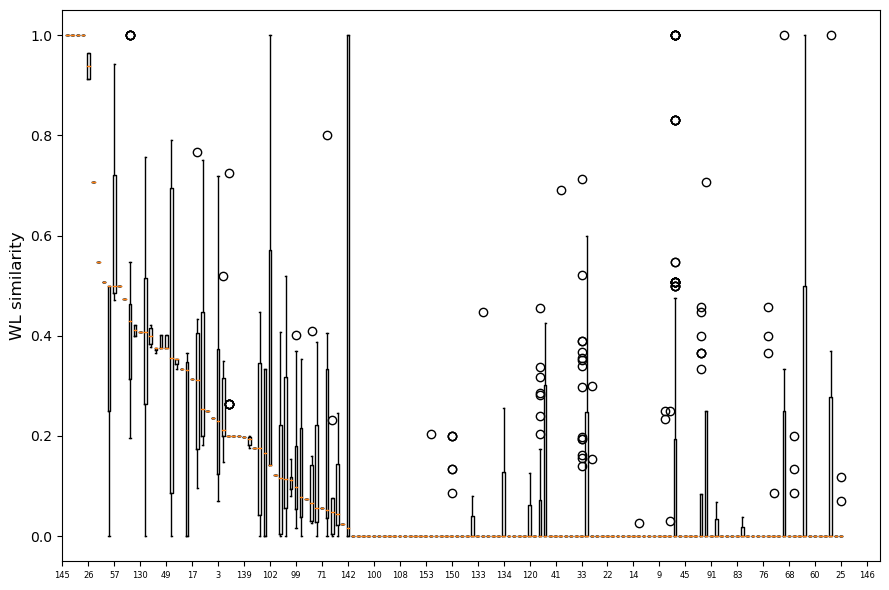

In [59]:
wl_df = pd.DataFrame({k:v for k,v in wl_dict.items() }.items())
wl_df['meds'] = [np.median(e) for e in wl_df[1]]
wl_df = wl_df.sort_values(by = 'meds', ascending = False)


fig, ax = plt.subplots(figsize = (9,6))
labels, data = list(zip((wl_df[0].values, wl_df[1].values)))
ax.boxplot(data[0], vert=True)  # Set vert=True to flip the axis



n = 5  # Change this to set the interval of tick labels
selected_indices = range(0, len(labels[0]), n)
selected_labels = [labels[0][i] for i in selected_indices]

# Set the selected tick positions and labels
plt.xticks(selected_indices, selected_labels, fontsize=6)

# Set x-axis ticks and labels

plt.ylabel('WL similarity', fontsize = 12)
plt.tight_layout()
fig.savefig(figures_dir/'WL similarity_201225.png', dpi = 300)